In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import umap

import matplotlib.pyplot as plt
import matplotlib
 
import pickle as pk
import h5py
import scanpy as sc

# Load data

Our algorithm requires at least two inputs:

- `count`$\in \mathbb{R}^{n_{\text{cell}}\ \ \times\ \ n_{\text{gene}}}$, the raw count matrix for the UMI/non-UMI model, or the preprocessed expression matrix for the Gaussian model.
- `NUM_CLUSTER`$\in \mathbb{N}^+$, the number of clusters.

One can also provides some prior information:

- `grouping`$\in \mathbb{R}^{n_{\text{cell}}}$, the true/estimated groupings
- `gene_names`$\in \mathbb{R}^{n_{\text{cell}}}$
- `cell_ids`$\in \mathbb{R}^{n_{\text{cell}}}$

We have prepare some datasets in **hdf5** format, which can be easily loaded by the following codes:

In [2]:
from scTrajVAE import get_igraph, louvain_igraph, plot_clusters, load_data

file_name = 'mouse_brain'
data = load_data(path='data/',
                 file_name=file_name)

# To see the available fields of the dataset
print(data.keys())

dict_keys(['count', 'grouping', 'gene_names', 'cell_ids', 'milestone_net', 'root_milestone_id', 'covariates', 'type'])


In [ ]:
# Remove cluster 8 & 15-18
data['grouping'] = data['grouping'].astype(object)
for g in ['08','15','16','17','18']:
    data['count'] = data['count'][data['grouping']!=g,:]
    data['covariates'] = data['covariates'][data['grouping']!=g,:]
    data['grouping'] = data['grouping'][data['grouping']!=g]  
    
# Combine cluster 1,3,10 and 4,7    
for g in ['01', '03', '10']:
    data['grouping'][data['grouping']==g] = '1-3-10'
    
for g in ['04', '07']:
    data['grouping'][data['grouping']==g] = '4-7'  

# Preprocess data

We follows the precedure

- Remove cells without expressions.
- Remove genes without variations across samples.
- Apply log-normalization to the count data $X$ and get $X_{\text{norm}}$.
- Select influential genes based on $X$ by the method described in Page 12-13: Data preprocessing - Feature selection for individual datasets, https://www.biorxiv.org/content/biorxiv/early/2018/11/02/460147.full.pdf.
- Apply per-gene standardization to $X_{\text{norm}}$ as the input of the neural network.


Removing 0 cells without expression.
Removing 1156 genes without variability.
min normailized value: 0.0
max normailized value: 8.082907


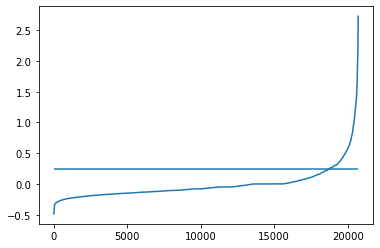

Number of cells in each class: 
0 <---> 00     1814
1 <---> 01     1143
10 <---> 10     429
11 <---> 11     404
12 <---> 12     261
13 <---> 13     220
14 <---> 14     213
15 <---> 15     142
16 <---> 16      50
17 <---> 17      32
18 <---> 18      25
2 <---> 02     1008
3 <---> 03      907
4 <---> 04      820
5 <---> 05      756
6 <---> 06      672
7 <---> 07      497
8 <---> 08      437
9 <---> 09      431
dtype: int64


In [3]:
from scTrajVAE import scTrajVAE

# clear the tf session if necessary
tf.keras.backend.clear_session() 

# create an instance
model = scTrajVAE()

# fit in data
model.get_data(data['count'],                   # count or expression matrix, (dense or sparse) numpy array 
               labels = data['grouping'],       # (optional) labels, which will be converted to string
               covariate = data['covariates'],  # (optional) covariates
               gene_names = data['gene_names'], # (optional) gene names, which will be converted to string
               cell_names = None                # (optional) cell names, which will be converted to string
              )

# preprocess data
model.preprocess_data(K = 1e4,                # (optional) denominator of the scale factor for log-normalization (the default is 1e4)
                      gene_num = 2000,        # (optional) maximum number of influential genes to keep (the default is 2000)
                      data_type = 'Gaussian',      # (optional) data_type can be 'UMI', 'non-UMI' or 'Gaussian' (the default is 'UMI')
                      npc = 64                # (optional) number of PCs to keep if data_type='Gaussian' (the default is 64)
                     )

# Build model

Now we are able to create the neural network.

In [4]:
model.build_model(dim_latent = 16,         # The size of the latent dimension
                  dimensions=[32]         # The size of each layer in the encoder between the input layer and the 
                                          # latent layer. The size of each layer in the decoder is the reverse.
                  )

# Pretrain

In the current stage, we only define the Autoencoder. The latent sturcture is still undefined. Before adding that, we'd better pretrain the Autoencoder to learn a better reprsentation $Z$ of $X$.

A large batch size will give a better and stable model, while it takes more memory to run. So if you are concerned about this, you could reduce the batch size.

In [5]:
model.pre_train(learning_rate = 1e-3,        # (Optional) the initial learning rate for the Adam optimizer (the default is 1e-3).
                batch_size=256,              # (Optional) the batch size for pre-training (the default is 32). 
                L=1,                         # (Optional) the number of MC samples (the default is 1).
                num_epoch = 300,             # (Optional) the maximum number of epoches (the default is 300).                
                num_step_per_epoch = None,   # (Optional) the number of step per epoch, it will be inferred from number of cells and batch size if it is None (the default is None).
                early_stopping_tolerance=1,  # (Optional) the minimum change of loss to be considered as an improvement (the default is 1e-3).
                early_stopping_patience=5,   # (Optional) the maximum number of epoches if there is no improvement (the default is 10).
                early_stopping_warmup=0,     # (Optional) the number of warmup epoches (the default is 0).
                path_to_weights=None         # (Optional) the path of weight file to be saved; not saving weight if None (the default is None).
                ) 

Pretrain - Start of epoch 0
41/41 [==============================] - 2s 60ms/step - Reconstructed Loss: 354.8927
 Training loss over epoch: 293.2528991699219
Pretrain - Start of epoch 1
41/41 [==============================] - 0s 12ms/step - Reconstructed Loss: 281.8614
 Training loss over epoch: 271.2287292480469
Pretrain - Start of epoch 2
41/41 [==============================] - 0s 12ms/step - Reconstructed Loss: 258.9556
 Training loss over epoch: 259.1951599121094
Pretrain - Start of epoch 3
41/41 [==============================] - 0s 12ms/step - Reconstructed Loss: 227.1147
 Training loss over epoch: 263.4845275878906
Pretrain - Start of epoch 4
41/41 [==============================] - 0s 12ms/step - Reconstructed Loss: 213.2124
 Training loss over epoch: 226.2693634033203
Pretrain - Start of epoch 5
41/41 [==============================] - 1s 12ms/step - Reconstructed Loss: 262.5158
 Training loss over epoch: 214.17613220214844
Pretrain - Start of epoch 6
41/41 [================

You can also save and load model weights by the following codes:

In [6]:
# save model weight
model.save_model(path_to_file='weight/mouse_brain_pre_train.checkpoint')

# load model weight
model.load_model(path_to_file='weight/mouse_brain_pre_train.checkpoint', # path to the weight file.
                 n_clusters=None                      # (Optional) parameter to initialize or re-initialize the GMM layer
                                                      # set to None if we don't know the number of clusters yet.
                )

# Clustering and initialize latent structure

## When prior of labeling is avialable

If you have information of the grouping/labels of cells, you are free to use them to initialze the latent structure, so that you will get better estimate and inference results, especially when the sample size is small or the classes are unbalanced.

In [9]:
# Get latent representations of X after pre-training
z = model.get_latent_z()

# Assign pre-given labels to initialize the latent structure
# The object 'model.labels' is encoded as categorical data from 'model.label_names'.
labels = model.label_names    

We can plot the clusters to see how it looks like.

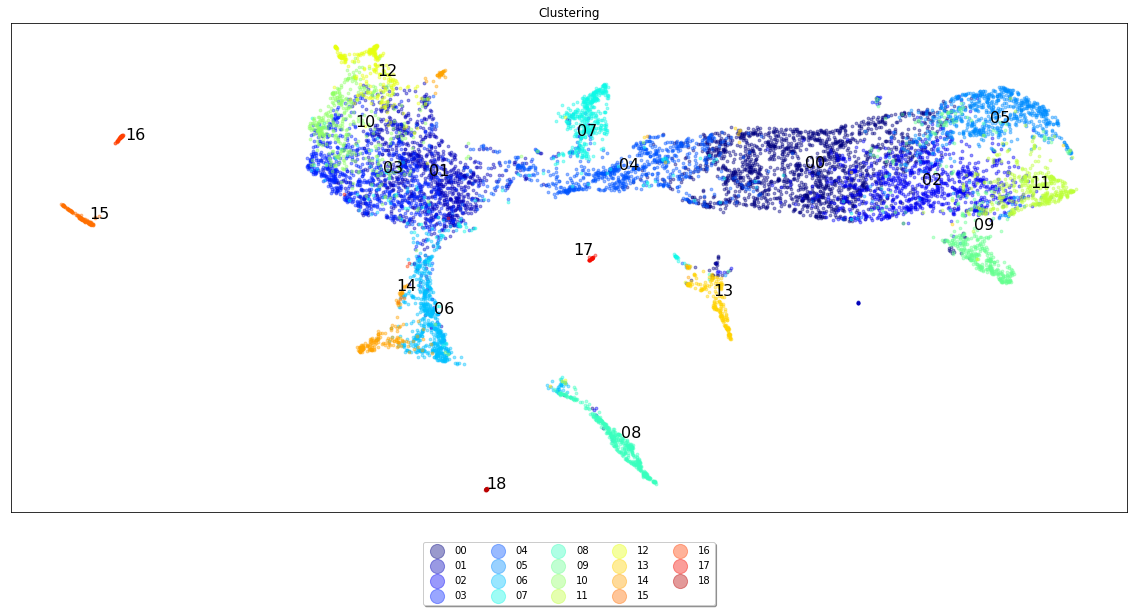

In [10]:
# Dimension reducation via UMAP. 
# You can also use tSNE, PCA and other dimension reduction algorithms.
embed_z = umap.UMAP().fit_transform(z)        
plot_clusters(embed_z, 
              model.label_names,
              plot_labels=True)

Suppose we want to select a subset of the cells. For example, we want to remove cluster '09' (which is encoded as 4), we can do:

```
cell_subsets = model.cell_names[labels != 4]
model.set_cell_subset(cell_subsets) 
# this will update the model variables 'selected_cell_subset' & 'selected_cell_subset_id',
# corresponding to cell names & cell ids respectively.
# However, if you do not select a subset, these two variables will also be initialzed to
# be include all cells.
labels = labels[model.selected_cell_subset_id]
z = z[model.selected_cell_subset_id,:]
```

Then the later operations, such as training and inference, will automatically only deal with the selected subset of cells. 

## When prior of labeling is not available

In such case, we can first apply any clustering algorithm like Louvain to obtain clusters.

[0 1 2 3 4 5 6 7 8]


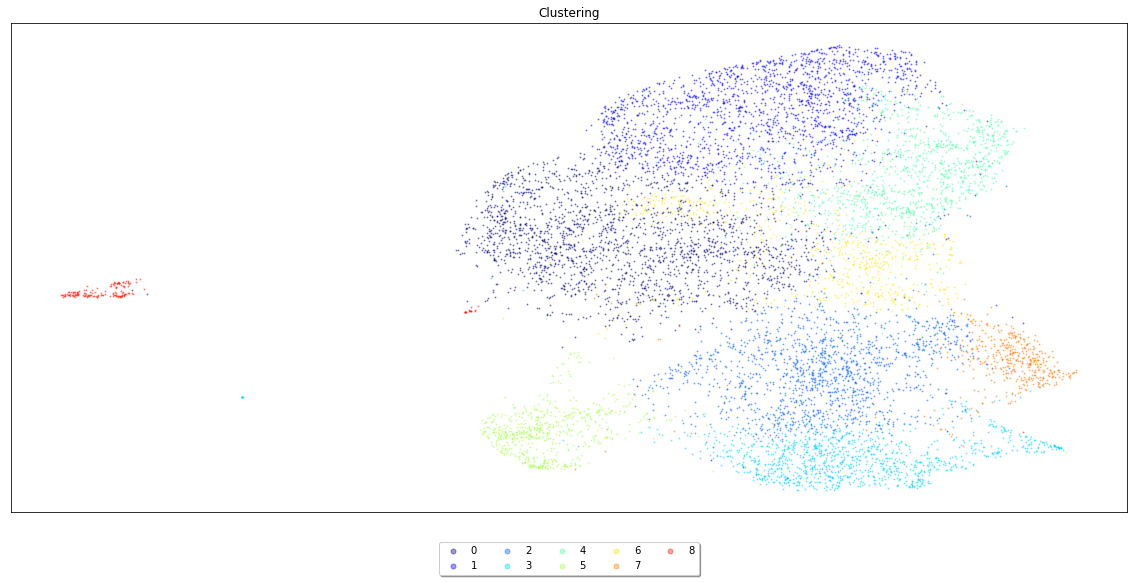

In [8]:
from scTGMVAE import get_igraph, louvain_igraph, plot_clusters
z = model.get_latent_z()
embed_z = umap.UMAP().fit_transform(z)
g = get_igraph(z)
labels = louvain_igraph(g, 0.6) # You can choose different resolution parameter to get satisfied clustering results.
plot_clusters(embed_z, labels)
print(np.unique(labels))

## Initialize latent structure

Now we need to determine $k$, either from prior information or clustering results. And we also need to initialze $\pi$ and $\mu$. 

- $\mu$: The user can provide $\mu$, the clustering centers. If not given, $\mu$ is initialized by the mean of each cluster corrsponding to the given clustering labels in latent space. If clustering labels are not given, $\mu$ is sampled from uniform $[-1,1]$.
- $\pi$: The user can provide $\pi=(\pi_{1,1},\cdots,\pi_{1,k},\pi_{2,2},\cdots,\pi_{2,k},\cdots, \pi_{k,k})\in\mathbb{R}^{1\times K}$, the prior proportion for each node and each edge. If not given, $\pi$ is uniformly initialized. 

In [11]:
NUM_CLUSTER = len(np.unique(labels))

model.init_latent_space(
    NUM_CLUSTER,                     # numebr of clusters
    cluster_labels=labels,           # (optional) clustering labels or their names for plotting
    mu=None,                         # (optional) initial mean
    log_pi=None                      # (optional) initial pi
               )                   

And we can also use estimated cluster labels from other algorithms and softwares.

# Train

In [12]:
model.train(learning_rate = 1e-3,        # (Optional) the initial learning rate for the Adam optimizer (the default is 1e-3).
            batch_size=256,              # (Optional) the batch size for pre-training (the default is 32). 
            L=1,                         # (Optional) the number of MC samples (the default is 1).
            num_epoch = 300,             # (Optional) the maximum number of epoches (the default is 300).                
            num_step_per_epoch = None,   # (Optional) the number of step per epoch, it will be inferred from number of cells and batch size if it is None (the default is None).
            early_stopping_tolerance=1,  # (Optional) the minimum change of loss to be considered as an improvement (the default is 1e-3).
            early_stopping_patience=5,   # (Optional) the maximum number of epoches if there is no improvement (the default is 10).
            early_stopping_warmup=0,     # (Optional) the number of warmup epoches (the default is 0).
            weight=2,
            plot_every_num_epoch=None,
            path_to_weights=None         # (Optional) the path of weight file to be saved; not saving weight if None (the default is None). 
            )

Warmup:0
Start of epoch 0
41/41 [==============================] - 3s 75ms/step - loss_neg_E_nb: 74.8655 - loss_neg_E_pz: 31.5405 - loss_E_qzx   : -7.5516 - loss_total: 119.7928
 Training loss over epoch: 116.03356170654297
 69.330727,  30.867947, -7.516539
Start of epoch 1
41/41 [==============================] - 2s 43ms/step - loss_neg_E_nb: 84.3477 - loss_neg_E_pz: 27.0975 - loss_E_qzx   : -7.8775 - loss_total: 109.8568
 Training loss over epoch: 111.27950286865234
 70.747910,  28.108477, -7.842679
Start of epoch 2
41/41 [==============================] - 2s 43ms/step - loss_neg_E_nb: 56.4892 - loss_neg_E_pz: 25.7997 - loss_E_qzx   : -8.2007 - loss_total: 112.0640
 Training loss over epoch: 108.02640533447266
 70.821793,  26.768581, -8.166283
Start of epoch 3
41/41 [==============================] - 2s 46ms/step - loss_neg_E_nb: 63.6741 - loss_neg_E_pz: 26.1796 - loss_E_qzx   : -8.5211 - loss_total: 105.9883
 Training loss over epoch: 105.37564086914062
 70.544502,  25.902573, -8.48

41/41 [==============================] - 2s 43ms/step - loss_neg_E_nb: 69.0166 - loss_neg_E_pz: 23.5860 - loss_E_qzx   : -16.3499 - loss_total: 85.8951
 Training loss over epoch: 89.16732788085938
 74.414536,  23.705502, -16.329107
Start of epoch 34
41/41 [==============================] - 2s 44ms/step - loss_neg_E_nb: 74.5874 - loss_neg_E_pz: 23.7488 - loss_E_qzx   : -16.5444 - loss_total: 86.5646
 Training loss over epoch: 86.2386703491211
 71.726501,  23.779879, -16.523800
Start of epoch 35
41/41 [==============================] - 2s 43ms/step - loss_neg_E_nb: 80.2844 - loss_neg_E_pz: 23.8014 - loss_E_qzx   : -16.7320 - loss_total: 83.0281
 Training loss over epoch: 85.6912841796875
 71.467842,  23.824181, -16.712460
Start of epoch 36
41/41 [==============================] - 2s 42ms/step - loss_neg_E_nb: 77.2650 - loss_neg_E_pz: 23.8565 - loss_E_qzx   : -16.9169 - loss_total: 79.6286
 Training loss over epoch: 85.81883239746094
 71.655563,  23.978804, -16.897167
Start of epoch 37
41

In [5]:
# save model weight
# model.save_model(path_to_file='weight/mouse_brain_train.checkpoint')

# load model weight
NUM_CLUSTER = len(np.unique(model.label_names))
model.load_model(path_to_file='weight/mouse_brain_train.checkpoint', # path to the weight file.
                 n_clusters=NUM_CLUSTER                      # (Optional) parameter to initialize or re-initialize the GMM layer
                                                      # set to None if we don't know the number of clusters yet.
                )
model.cluster_labels = model.label_names

# Inference

## Trajectory and Pseudotime

In [10]:
# initialze inference
model.init_inference(batch_size=64, L=10) # L is the number of MC samples
# after initialization, we can access some variables by model.pc_x, model.w, model.w_tilde, etc..

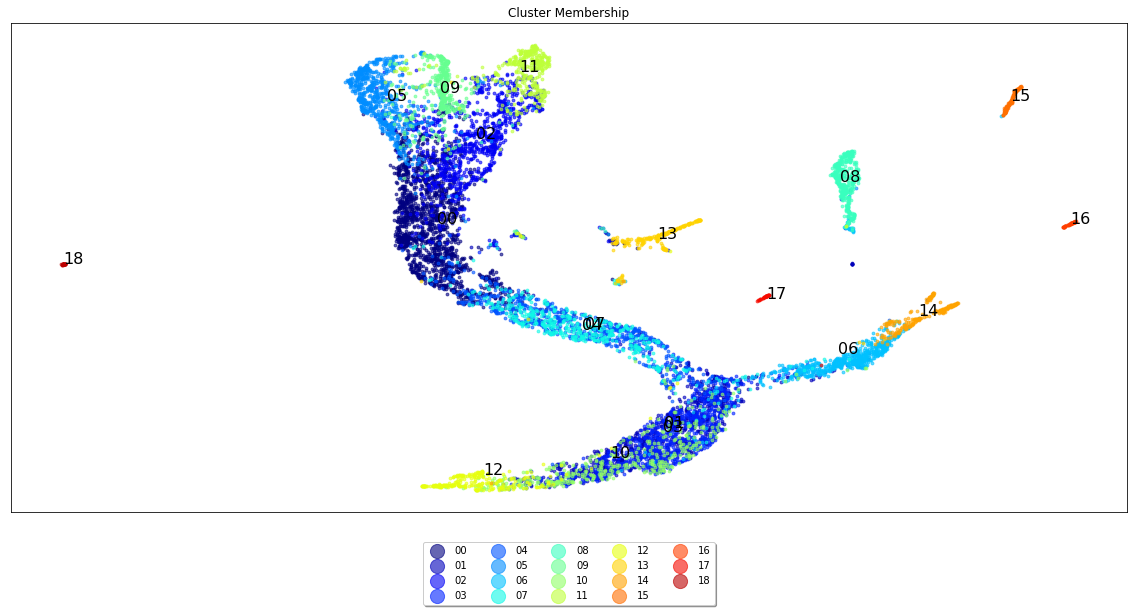

[[ 0.    0.    0.41  0.    0.    0.39  0.    0.    0.    0.    0.    0.
   0.    0.13  0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.   16.73  0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.07  0.12  0.  ]
 [ 0.41  0.    0.    0.    0.    0.    0.    0.48  0.    0.16  0.    0.37
   0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.   16.73  0.    0.    5.69  0.    1.67  2.83  0.    0.    1.94  0.
   0.52  0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    5.69  0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.39  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    1.67  0.    0.    0.    0.    0.12  0.    0.    0.
   0.    0.    0.37  0.12  0.    0.    0.  ]
 [ 0.    0.    0.48  2.83  0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.12  0.    0.    0.   

In [11]:
import networkx as nx
# compute inference score, and get umap embedding
# a plot of clustering result will be displayed
G = model.comp_inference_score(method='modified_map',  # 'mean', 'modified_mean', 'map', and 'modified_map'
                               thres=0.5,              # (Optional) threshold for compute the conditional probablity, only applies to 'mean' and 'modified_mean'
                               no_loop=True            # if no_loop=True, then find the maximum spanning tree
                               )           
# returned G is the score graph
print(np.round(nx.to_numpy_matrix(G), 2))
print(G.edges)

Now, the user needs to provide the initial node for the trajectory.

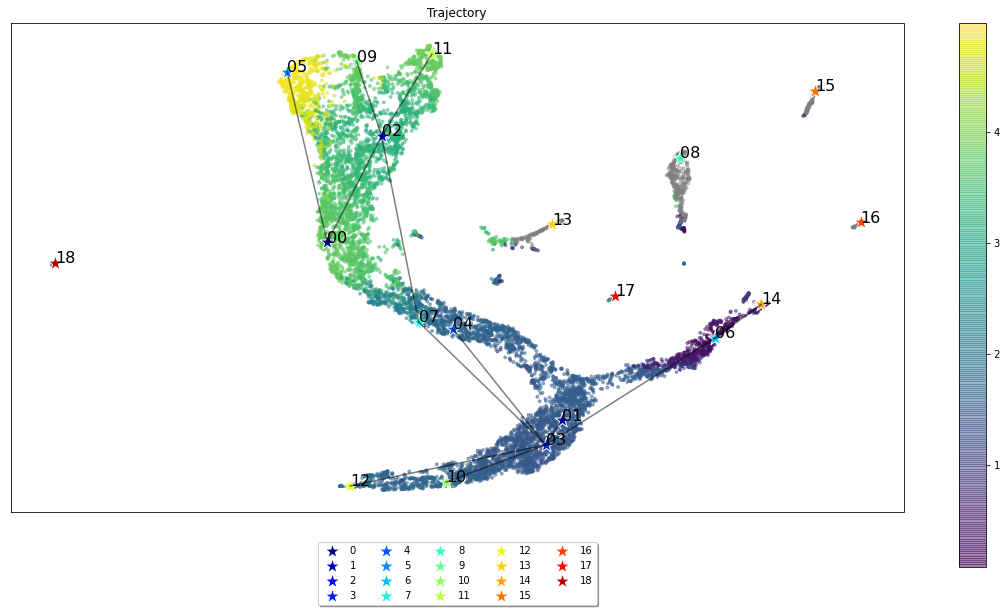

(<networkx.classes.graph.Graph at 0x7fd2d1fdbd30>,
 array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.18417259, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.5206308 , 0.        , 0.47936925, ..., 0.        , 0.        ,
         0.        ],
        [0.10562443, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]], dtype=float32),
 array([ 0.39973712, -1.        ,  0.11894333, ...,  4.81582737,
         3.52063084,  4.8943758 ]))

In [12]:
# Here we identify the 'begin_node_pred' as the one having minimum average 
# distance with the cells in the true begin node.
begin_node_true = model.le.transform([data['root_milestone_id']])[0]
begin_node_pred = int(np.argmin(np.mean((
                        model.z[model.labels[model.selected_cell_subset_id]==begin_node_true,:,np.newaxis] - 
                        model.mu[np.newaxis,:,:])**2, axis=(0,1))))
model.infer_trajectory(init_node=begin_node_pred,  # initial node for computing pseudotime.
                       cutoff=0.13                 # (Optional) cutoff score for edges (the default is 0.01).
                       )  

## Marker Genes

In [9]:
model.gene_names

array(['Slc38a10', 'Rad18', 'Grm8', ..., 'Med29', 'Diablo', 'Gpsm1'],
      dtype='<U14')

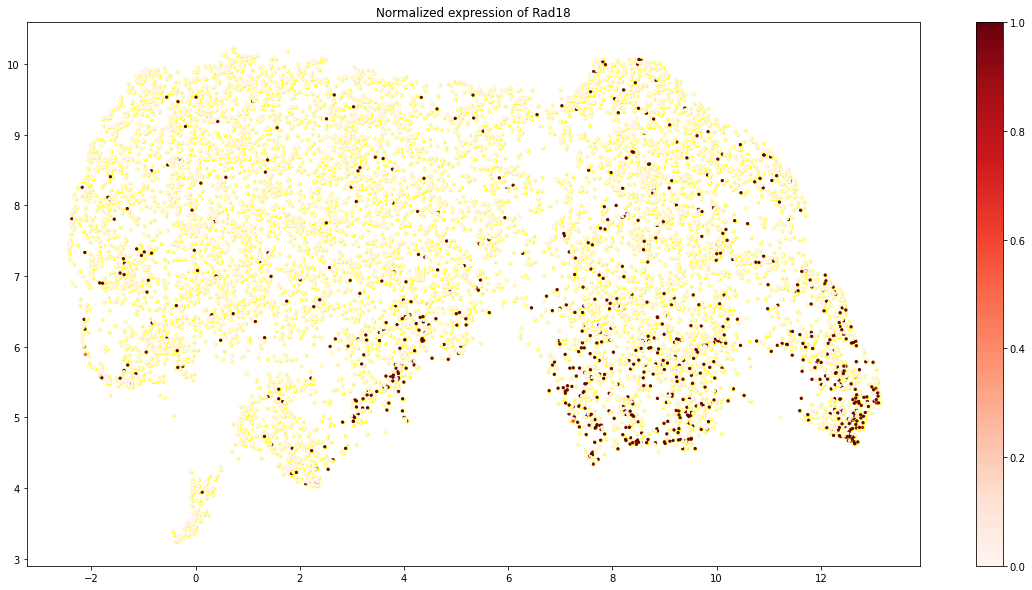

In [9]:
model.plot_marker_gene('Rad18')